In [1]:
import os
import sys
import traceback
import gc
import time
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import itertools

import warnings
warnings.simplefilter('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp075"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.630 # local_cvの結果を入れる
    base_exp = "exp074" # 特徴量重要度を使う元のexp
    n_features = 500 # 特徴量削減の数
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder_310

In [3]:
def calc_metrics(oof):
    logloss = log_loss(oof["correct"], oof["pred"])

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    #print("logloss", format(logloss, ".6f"))
    #print("best_score", format(best_score, ".6f"))
    #print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    #print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        #print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_score

In [9]:
exp = "exp101-cat"
oof = pd.read_csv(cfg.output_dir + f"{exp}/oof.csv.gz")

In [10]:
oof

,session_id,question,pred,correct
0,20090312433251036,1,1.004271,0
1,20090314121766812,1,0.730852,1
2,20090315085850788,1,1.621245,1
3,20090316190523732,1,2.157416,1
4,20100006432365430,1,0.656938,0
...,...,...,...,...
424111,22090619362224080,18,1.333075,1
424112,22100208551963804,18,3.833276,1
424113,22100211280762644,18,4.343314,1
424114,22100213133089136,18,4.694082,1


In [18]:
session_ids = pd.read_csv(cfg.input_dir + "train.csv")["session_id"].unique().tolist()

In [26]:
oof[oof["session_id"].isin(selected_sessions)]

,session_id,question,pred,correct
0,20090312433251036,1,0.737633,0
3,20090316190523732,1,0.946037,1
6,20100009560590796,1,0.230756,0
7,20100011050028640,1,0.462104,1
8,20100011394713344,1,0.407428,1
...,...,...,...,...
424110,22090618055201484,18,0.981225,1
424112,22100208551963804,18,0.982150,1
424113,22100211280762644,18,0.988087,1
424114,22100213133089136,18,0.986209,1


In [43]:
dfs = []
for exp in ["exp090", "exp091", "exp096"]:
    scores = []
    oof = pd.read_csv(cfg.output_dir + f"{exp}/oof.csv.gz")
    for i in tqdm(range(100)):
        random.seed(i)
        selected_sessions = random.sample(session_ids, 10000)
        oof_sample = oof[oof["session_id"].isin(selected_sessions)].copy()
        score = calc_metrics(oof_sample)
        scores.append(score)
    tmp = pd.DataFrame({"score": scores})
    tmp["exp"] = exp
    dfs.append(tmp)
result = pd.concat(dfs, ignore_index=True)

100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


<AxesSubplot: xlabel='score', ylabel='Count'>

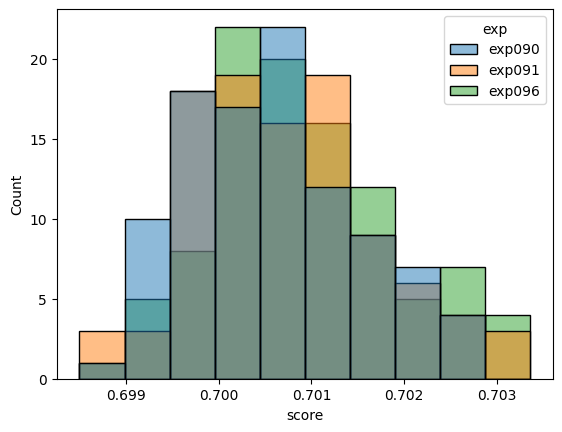

In [44]:
sns.histplot(result, x="score", hue="exp", bins=10)

In [47]:
result.groupby("exp").agg(["mean", "max", "min", "std"])

score                              
            mean       max       min       std
exp                                           
exp090  0.700610  0.702850  0.698805  0.000910
exp091  0.700732  0.703161  0.698496  0.000988
exp096  0.700898  0.703362  0.698727  0.000988

In [51]:
result["idx"] = result.groupby("exp").cumcount()

<AxesSubplot: xlabel='idx', ylabel='score'>

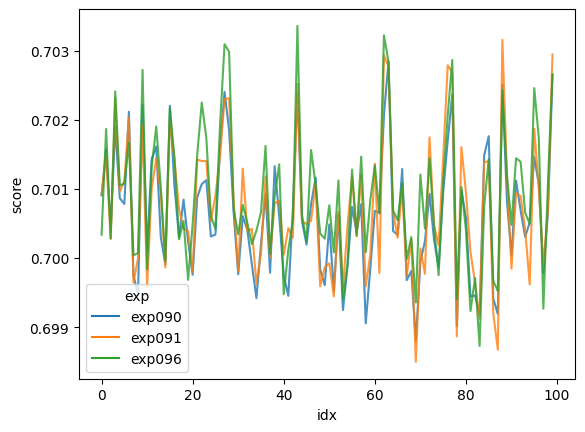

In [54]:
sns.lineplot(result, x="idx", y="score", hue="exp", alpha=0.8)

In [83]:
dfs = []
for exp in ["exp090", "exp091", "exp096"]:
    scores = []
    oof = pd.read_csv(cfg.output_dir + f"{exp}/oof.csv.gz")
    for y in ["20","21","22"]:
        selected_sessions = [session for session in session_ids if str(session).startswith(y)]
        #random.seed(0)
        #selected_sessions = random.sample(selected_sessions, 3000)
        oof_sample = oof[oof["session_id"].isin(selected_sessions)].copy()
        score = calc_metrics(oof_sample)
        scores.append(score)
    tmp = pd.DataFrame({"score": scores})
    tmp["exp"] = exp
    tmp["y"] = ["20","21","22"]
    dfs.append(tmp)
result2 = pd.concat(dfs, ignore_index=True)

In [84]:
result2

,score,exp,y
0,0.703544,exp090,20
1,0.698630,exp090,21
2,0.703821,exp090,22
3,0.703085,exp091,20
4,0.698978,exp091,21
5,0.703916,exp091,22
6,0.704168,exp096,20
7,0.698744,exp096,21
8,0.704540,exp096,22


<AxesSubplot: xlabel='y', ylabel='score'>

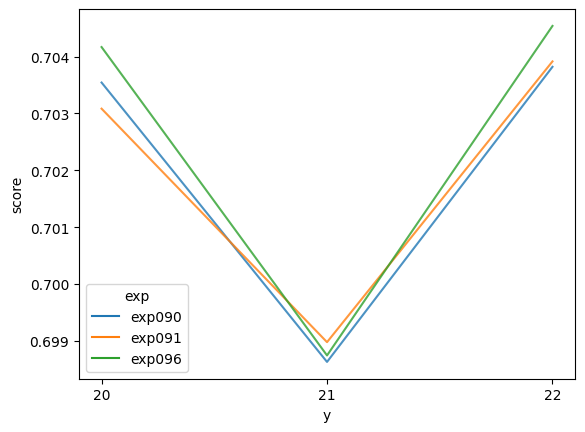

In [85]:
sns.lineplot(result2, x="y", y="score", hue="exp", alpha=0.8)

In [151]:
oof["session_id"].drop_duplicates().astype(str).str[:2].value_counts().to_frame().sort_index()

,session_id
20,3108
21,15292
22,5162


In [114]:
oof["session_id"].drop_duplicates().astype(str).str[:4].value_counts().to_frame().sort_index()

,session_id
2009,25
2010,1272
2011,1811
2100,2032
2101,1872
2102,2123
2103,1836
2104,1992
2105,1208
2106,329


In [115]:
yms = oof["session_id"].astype(str).str[:4].unique().tolist()
yms.remove("2009")
yms.remove("2210")

In [118]:
dfs = []
for exp in ["exp090", "exp091", "exp096"]:
    scores = []
    oof = pd.read_csv(cfg.output_dir + f"{exp}/oof.csv.gz")
    for ym in yms:
        selected_sessions = [session for session in session_ids if str(session).startswith(ym)]
        #random.seed(0)
        #selected_sessions = random.sample(selected_sessions, 200)
        oof_sample = oof[oof["session_id"].isin(selected_sessions)].copy()
        score = calc_metrics(oof_sample)
        scores.append(score)
    tmp = pd.DataFrame({"score": scores})
    tmp["exp"] = exp
    tmp["ym"] = yms
    dfs.append(tmp)
result3 = pd.concat(dfs, ignore_index=True)

<AxesSubplot: xlabel='ym', ylabel='score'>

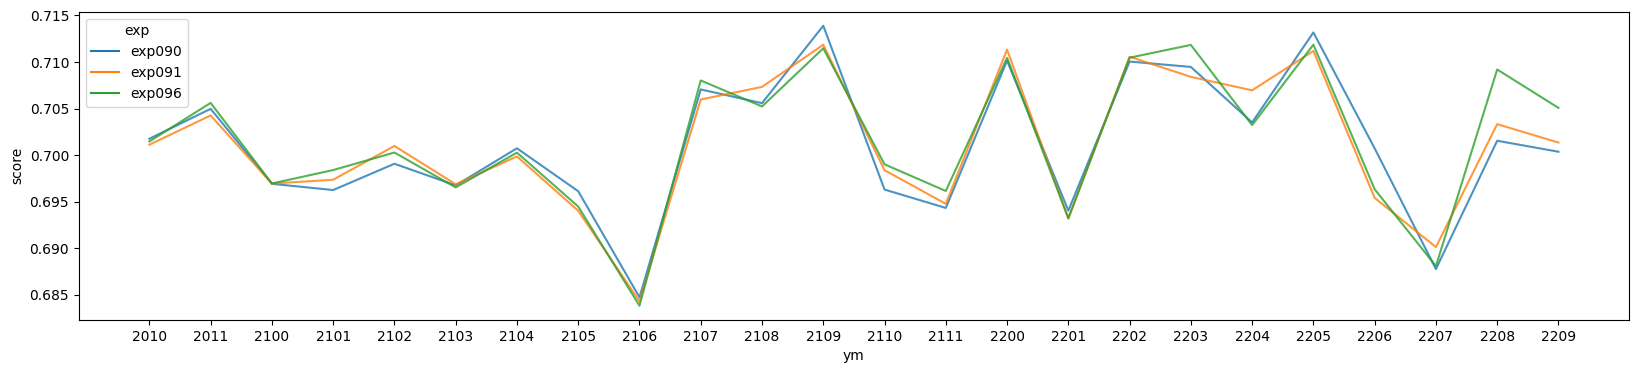

In [119]:
plt.figure(figsize=(20,4))
sns.lineplot(result3, x="ym", y="score", hue="exp", alpha=0.8)

100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


<AxesSubplot: xlabel='score', ylabel='Count'>

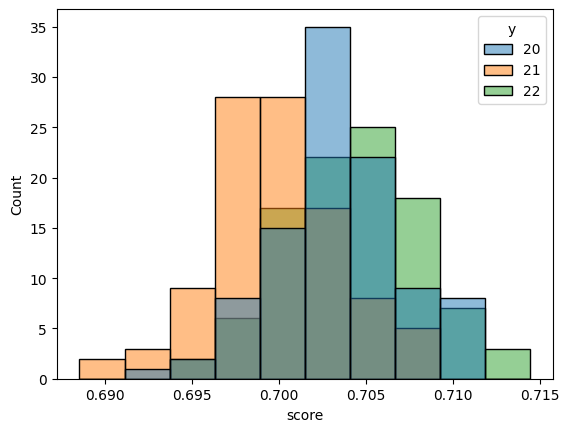

In [152]:
dfs = []
for y in ["20", "21", "22"]:
    scores = []
    oof = pd.read_csv(cfg.output_dir + f"exp090/oof.csv.gz")
    y_sessions = [session for session in session_ids if str(session).startswith(y)]
    for i in tqdm(range(100)):
        random.seed(i)
        selected_sessions = random.sample(y_sessions, 1000)
        oof_sample = oof[oof["session_id"].isin(selected_sessions)].copy()
        score = calc_metrics(oof_sample)
        scores.append(score)
    tmp = pd.DataFrame({"score": scores})
    tmp["y"] = y
    dfs.append(tmp)
result4 = pd.concat(dfs, ignore_index=True)
sns.histplot(result4, x="score", hue="y", bins=10)

100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


<AxesSubplot: xlabel='score', ylabel='Count'>

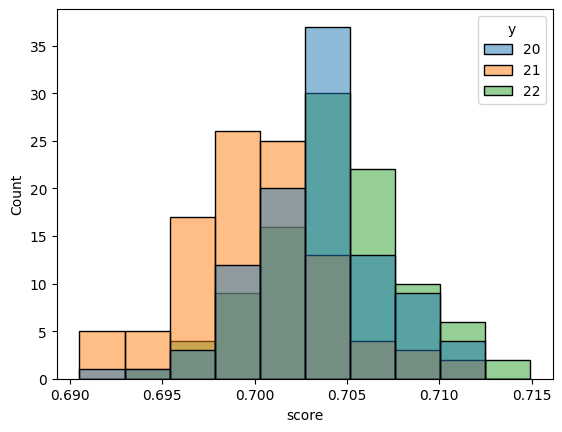

In [153]:
dfs = []
for y in ["20", "21", "22"]:
    scores = []
    oof = pd.read_csv(cfg.output_dir + f"exp091/oof.csv.gz")
    y_sessions = [session for session in session_ids if str(session).startswith(y)]
    for i in tqdm(range(100)):
        random.seed(i)
        selected_sessions = random.sample(y_sessions, 1000)
        oof_sample = oof[oof["session_id"].isin(selected_sessions)].copy()
        score = calc_metrics(oof_sample)
        scores.append(score)
    tmp = pd.DataFrame({"score": scores})
    tmp["y"] = y
    dfs.append(tmp)
result4 = pd.concat(dfs, ignore_index=True)
sns.histplot(result4, x="score", hue="y", bins=10)

100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


<AxesSubplot: xlabel='score', ylabel='Count'>

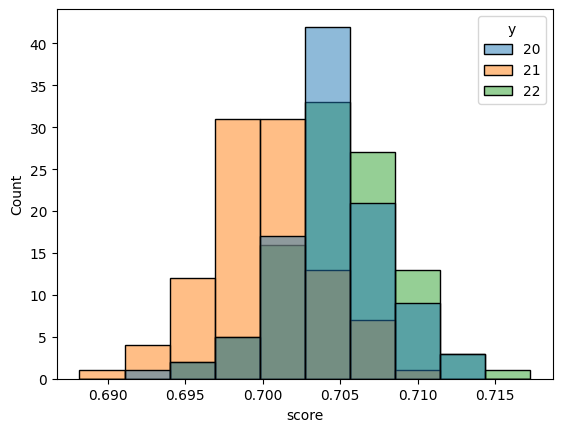

In [154]:
dfs = []
for y in ["20", "21", "22"]:
    scores = []
    oof = pd.read_csv(cfg.output_dir + f"exp096/oof.csv.gz")
    y_sessions = [session for session in session_ids if str(session).startswith(y)]
    for i in tqdm(range(100)):
        random.seed(i)
        selected_sessions = random.sample(y_sessions, 1000)
        oof_sample = oof[oof["session_id"].isin(selected_sessions)].copy()
        score = calc_metrics(oof_sample)
        scores.append(score)
    tmp = pd.DataFrame({"score": scores})
    tmp["y"] = y
    dfs.append(tmp)
result4 = pd.concat(dfs, ignore_index=True)
sns.histplot(result4, x="score", hue="y", bins=10)

In [128]:
train_old = pd.read_csv(cfg.input_dir + "_old/train.csv")
train = pd.read_csv(cfg.input_dir + "train.csv")
test_old = train[~train["session_id"].isin(train_old["session_id"].unique().tolist())].reset_index(drop=True)

In [127]:
train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13174206,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174207,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174208,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,NaN,NaN,NaN,13-22


In [139]:
tmp1 = train_old.drop_duplicates(subset="session_id")["session_id"].astype(str).str[:4].value_counts().to_frame().reset_index()
tmp1["t"] = "train"

tmp2 = test_old.drop_duplicates(subset="session_id")["session_id"].astype(str).str[:4].value_counts().to_frame().reset_index()
tmp2["t"] = "test"

ym_cnts = pd.concat([tmp1, tmp2], ignore_index=True)
ym_cnts = ym_cnts.sort_values("index")

<AxesSubplot: xlabel='index', ylabel='session_id'>

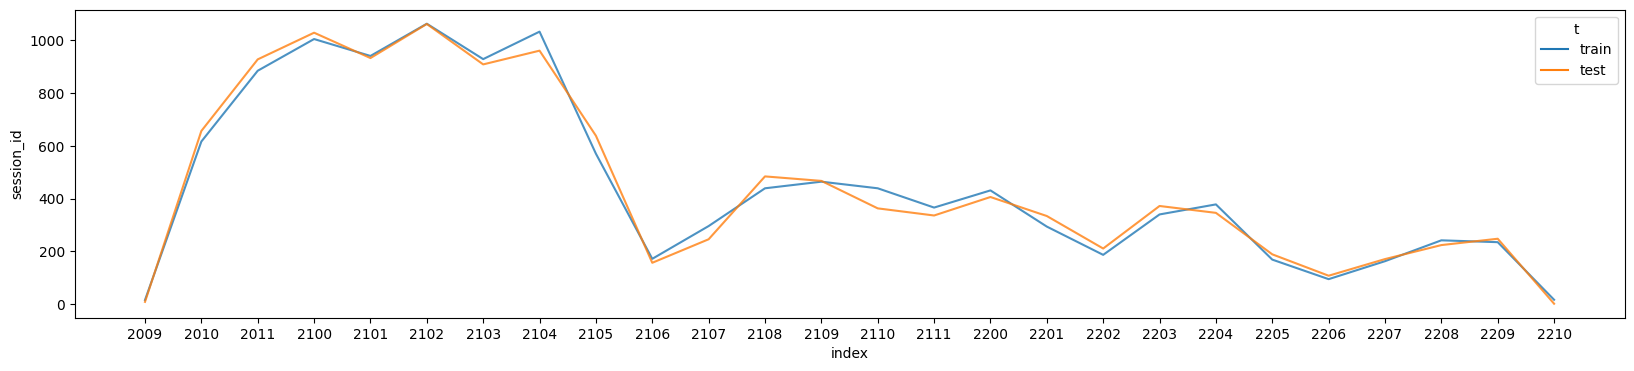

In [141]:
plt.figure(figsize=(20,4))
sns.lineplot(ym_cnts, x="index", y="session_id", hue="t", alpha=0.8)

In [143]:
train_session_ids = train_old["session_id"].unique().tolist()
test_session_ids = test_old["session_id"].unique().tolist()

In [146]:
tmp

,score
0,0.700539
1,0.699072
2,0.700075
3,0.700588
4,0.699643
...,...
95,0.699952
96,0.700318
97,0.699293
98,0.699108


In [149]:
dfs = []
for t in ["train", "test"]:
    scores = []
    oof = pd.read_csv(cfg.output_dir + f"exp090/oof.csv.gz")
    if t == "train":
        t_sessions = train_session_ids
    else:
        t_sessions = test_session_ids
    for i in tqdm(range(100)):
        random.seed(i)
        selected_sessions = random.sample(t_sessions, 1000)
        oof_sample = oof[oof["session_id"].isin(selected_sessions)].copy()
        score = calc_metrics(oof_sample)
        scores.append(score)
    tmp = pd.DataFrame({"score": scores})
    tmp["t"] = t
    dfs.append(tmp)
result5 = pd.concat(dfs, ignore_index=True)

100%|██████████| 100/100 [00:23<00:00,  4.32it/s]


<AxesSubplot: xlabel='score', ylabel='Count'>

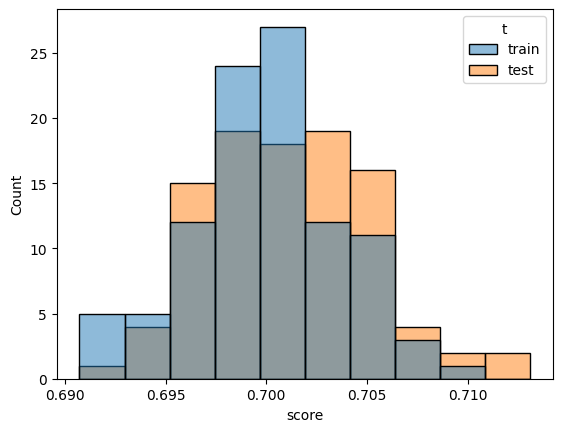

In [150]:
sns.histplot(result5, x="score", hue="t", bins=10)

In [157]:
labels = pd.read_csv(cfg.input_dir + "train_labels.csv")
labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)

In [159]:
labels["year"] = labels["session_id"].astype(str).str[:2]

In [162]:
correct_rate = labels.groupby(["year", "question"])["correct"].mean().reset_index()

<AxesSubplot: xlabel='question', ylabel='correct'>

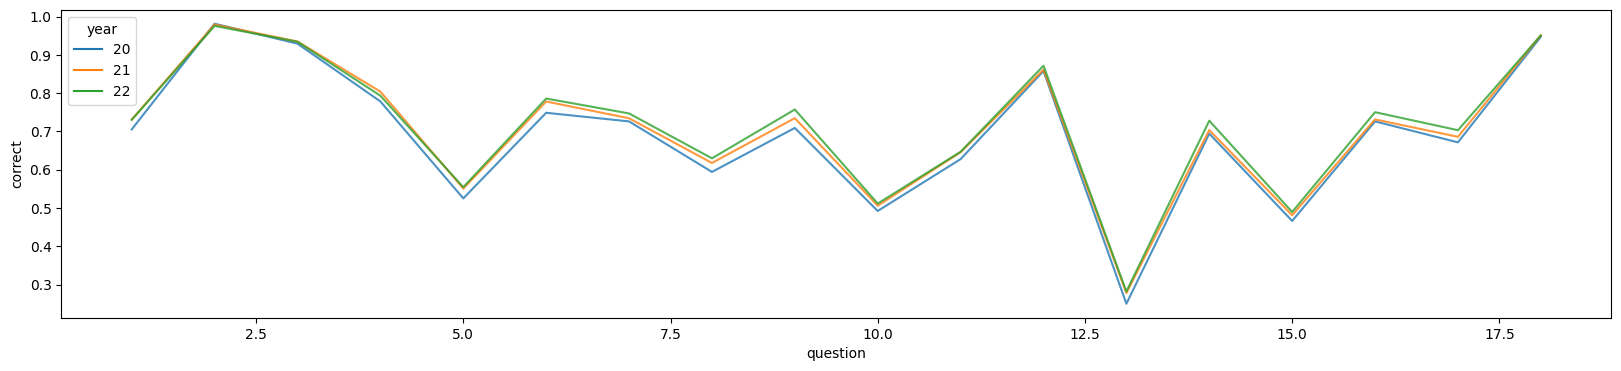

In [163]:
plt.figure(figsize=(20,4))
sns.lineplot(correct_rate, x="question", y="correct", hue="year", alpha=0.8)

In [156]:
labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1
...,...,...
424111,22100215342220508_q18,1
424112,22100215460321130_q18,1
424113,22100217104993650_q18,1
424114,22100219442786200_q18,1


In [77]:
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, precision_recall_curve

In [20]:
exp_s = ["exp050", "exp064", "exp074", "exp075"]
lb_s = [0.694, 0.699, 0.698, 0.696]
f1_s = []
logloss_s = []
auc_s = []
pr_auc_s = []



for exp in exp_s:
    oof = pd.read_csv(cfg.output_dir + f"{exp}/oof.csv.gz")
    f1_s.append(calc_metrics(oof))
    logloss_s.append(log_loss(oof["correct"], oof["pred"]))
    auc_s.append(roc_auc_score(oof["correct"], oof["pred"]))
    pr_auc_s.append(average_precision_score(oof["correct"], oof["pred"]))

<AxesSubplot: >

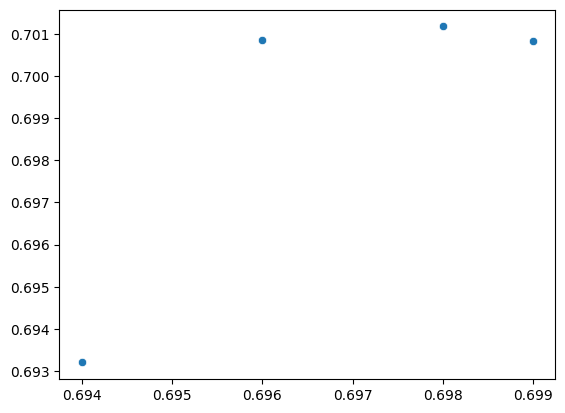

In [37]:
sns.scatterplot(x=lb_s, y=f1_s, legend=exp_s)

<AxesSubplot: >

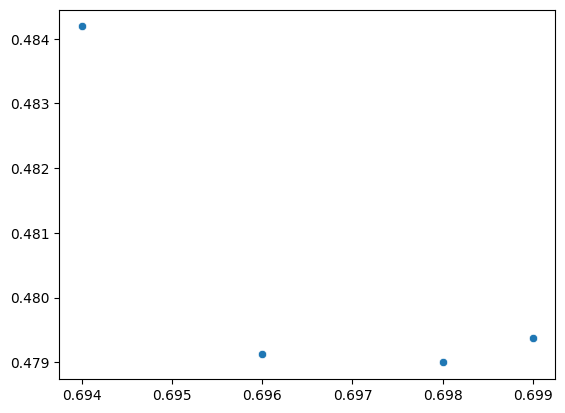

In [23]:
sns.scatterplot(x=lb_s, y=logloss_s)

<AxesSubplot: >

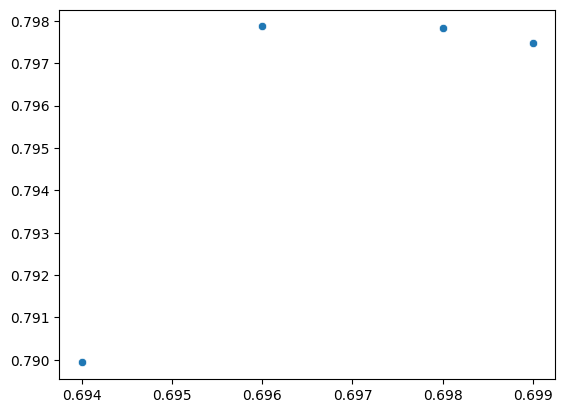

In [24]:
sns.scatterplot(x=lb_s, y=auc_s)

<AxesSubplot: >

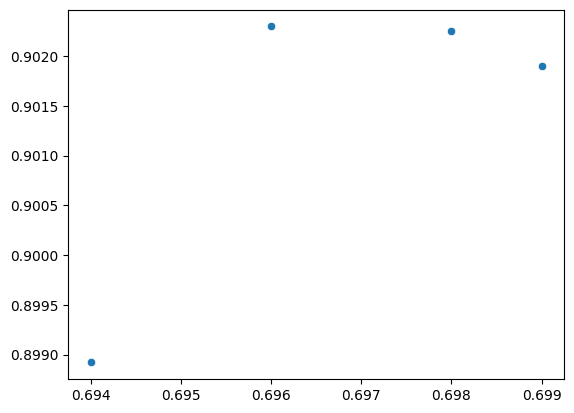

In [25]:
sns.scatterplot(x=lb_s, y=pr_auc_s)

In [72]:
pd.read_csv(cfg.prep_dir + f"train0-4_cleaned.csv")["session_id"].nunique()

23562

In [62]:
df.dtypes

session_id      int64
question       object
pred          float64
dtype: object

In [73]:
for exp in ["exp050", "exp051", "exp062", "exp063", "exp064", "exp074", "exp075"]:
    oof = pd.read_csv(cfg.output_dir + f"{exp}/oof.csv.gz")
    print(exp, oof["session_id"].nunique())

exp050 23562
exp051 23562
exp062 23562
exp063 4712
exp064 4712
exp074 4712
exp075 4712


In [64]:
df = pd.read_parquet(cfg.output_dir + "eikichi/oof.parquet")
df = df.stack().reset_index()
df.columns = ["session_id", "question", "pred"]
df["question"] = df["question"].astype(int)
df = df.merge(oof[["session_id", "question", "correct"]], on=["session_id", "question"], how="left")

In [68]:
df["session_id"].nunique()

23562

In [69]:
oof["session_id"].nunique()

4712

In [59]:
train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}_cleaned.csv")

,session_id,question,pred,correct
0,20090314035813970,1,0.558399,1
1,20090315081004164,1,0.583582,0
2,20090316152177500,1,0.672174,1
3,20090318021527530,1,0.496427,0
4,20100000404860470,1,0.481753,1
...,...,...,...,...
84811,22090619362224080,18,0.839989,1
84812,22100208551963804,18,0.985578,1
84813,22100211280762644,18,0.985838,1
84814,22100213133089136,18,0.987624,1


,session_id,level_1,0
0,20090312431273200,1,0.942801
1,20090312431273200,2,0.988234
2,20090312431273200,3,0.987180
3,20090312431273200,4,0.921669
4,20090312431273200,5,0.793807
...,...,...,...
424111,22100221145014656,14,0.448897
424112,22100221145014656,15,0.161155
424113,22100221145014656,16,0.594893
424114,22100221145014656,17,0.506732


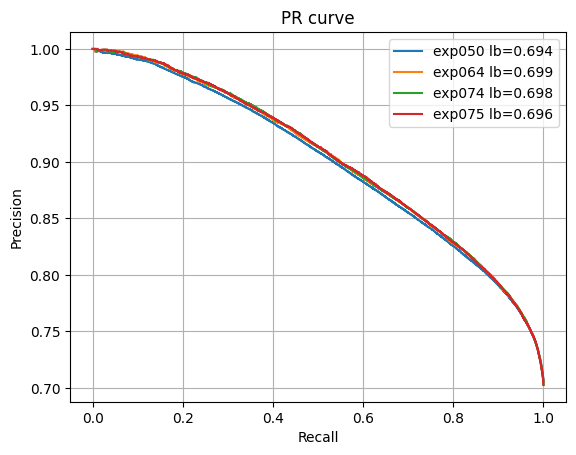

In [41]:
for i, exp in enumerate(exp_s):
    oof = pd.read_csv(cfg.output_dir + f"{exp}/oof.csv.gz")
    precision, recall, thresholds = precision_recall_curve(oof["correct"], oof["pred"])
    plt.plot(recall, precision,label=f"{exp} lb={str(lb_s[i])}")
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
plt.show()

In [52]:
cvs = []
for i in range(100):
    selected_sessions = np.random.choice(sessions, 2000)
    tmp = oof[oof["session_id"].isin(selected_sessions)].reset_index(drop=True)
    cvs.append(calc_metrics(tmp))

(array([ 3.,  7., 17., 20., 22., 16., 10.,  4.,  0.,  1.]),
 array([0.69476167, 0.69631731, 0.69787295, 0.6994286 , 0.70098424,
        0.70253988, 0.70409552, 0.70565117, 0.70720681, 0.70876245,
        0.71031809]),
 <BarContainer object of 10 artists>)

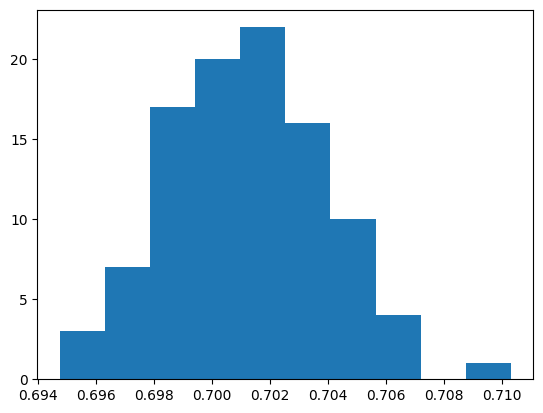

In [54]:
plt.hist(cvs)

In [49]:
tmp

,session_id,question,pred,correct
10,20100012471966900,1,0.871635,0
11,20100012562027690,1,0.808620,0
15,20100016263918300,1,0.365200,1
20,20100020122406090,1,0.756985,1
21,20100022495909980,1,0.797349,1
...,...,...,...,...
84804,22090612541374216,18,0.983052,1
84805,22090613470228436,18,0.932779,1
84809,22090617092908200,18,0.975457,1
84813,22100211280762644,18,0.985838,1


In [44]:
len(oof["session_id"].unique())

4712

In [18]:
f1_s.append(calc_metrics(oof))

In [19]:
f1_s

[0.693203264578593, 0.693203264578593]

In [12]:
def run_train():
    oofs = []
    prev_features_df = None # 次のlevel_groupで特徴量を使うための保持データ。0-4は前のlevel_groupがないので初期値はNone
    for group in level_group_list:
        print(group)
        # データ読み込み
        train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}_cleaned.csv")
        labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
        train = get_train_dataset(train_sessions, labels)

        # 一つ前のlevel_groupの特徴量を追加
        if prev_features_df is not None:
            train = train.merge(prev_features_df, on=["session_id"], how="left")
        else:
            pass

        # 前のlevel_groupのquestionパートの経過時間特徴量
        if group == "5-12":
            train["0-4_question_duration_time"] = train["5-12_elapsed_time_min"] - train["0-4_elapsed_time_max"]
            train["0-4_question_duration_index"] = train["5-12_index_min"] - train["0-4_index_max"]
        elif group == "13-22":
            train["5-12_question_duration_time"] = train["13-22_elapsed_time_min"] - train["5-12_elapsed_time_max"]
            train["5-12_question_duration_index"] = train["13-22_index_min"] - train["5-12_index_max"]
    
        target = "correct"
        not_use_cols = [target, "session_id", "level_group"]
        features = [c for c in train.columns if c not in not_use_cols]

        # 特徴量選択
        if cfg.base_exp is None:
            not_drop_cols = ["0-4_elapsed_time_max", "0-4_index_max", "5-12_elapsed_time_max", "5-12_index_max", "13-22_elapsed_time_max", "13-22_index_max",
                            "0-4_elapsed_time_min", "0-4_index_min", "5-12_elapsed_time_min", "5-12_index_min", "13-22_elapsed_time_min", "13-22_index_min"]
            features = FeaturesSelect(train, features, not_drop_cols).features_select()
        else:
            # 使用する特徴量の抽出
            features = pd.read_csv(cfg.output_dir + f"{cfg.base_exp}/fi_{group}.csv").head(cfg.n_features)["feature"].tolist()

        gkf = GroupKFold(n_splits=cfg.n_splits)
        fis = []
        
        for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model_{group}_{i}.lgb"
            oof_groups = []
            print(f"fold : {i}")
            tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
            vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
            tr_data = lgb.Dataset(tr_x, label=tr_y)
            vl_data = lgb.Dataset(vl_x, label=vl_y)

            if os.path.exists(model_path):
                print(f"modelが既に存在するのでロード : {model_path}")
                model = lgb.Booster(model_file=model_path)
            else:
                model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                                num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
            # モデル出力
            model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model_{group}_{i}.lgb")
        
            # valid_pred
            oof_fold = train.iloc[vl_idx].copy()
            oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
            oof_groups.append(oof_fold)

            # 特徴量重要度
            fi_fold = pd.DataFrame()
            fi_fold["feature"] = model.feature_name()
            fi_fold["importance"] = model.feature_importance(importance_type="gain")
            fi_fold["fold"] = i
            fis.append(fi_fold)

        fi = pd.concat(fis)    
        fi = fi.groupby("feature")["importance"].mean().reset_index()
        fi = fi.sort_values("importance", ascending=False).reset_index(drop=True)
        fi.to_csv(cfg.output_dir + f"{cfg.exp_name}/fi_{group}.csv", index=False)

        oof_group = pd.concat(oof_groups)
        oofs.append(oof_group)

        # 次のlevel_groupで使う用に特徴量を保持
        prev_features_df = train.groupby("session_id").head(1).drop(columns=["question", "correct", "level_group"])

        # meta_featureの付与
        meta_df = oof_group.groupby("session_id")["pred"].agg(["mean", "max", "min", "std"]).reset_index()
        meta_df = meta_df.rename(columns={"mean":f"{group}_pred_mean", "max":f"{group}_pred_max", "min":f"{group}_pred_min", "std":f"{group}_pred_std"})
        prev_features_df = prev_features_df.merge(meta_df, on="session_id", how="left")

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof[["session_id", "question", "pred", "correct"]].to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip", index=False)

In [13]:
def get_mock_iter_train():
    """trainデータのiter分割を適用したtest_sample
    """
    test = pd.read_csv(cfg.input_dir + "_old/test.csv")
    sub = pd.read_csv(cfg.input_dir + "_old/sample_submission.csv")
    sub["level_group"] = sub["session_level"].apply(lambda x: x.split("_")[-1])
    
    # groupbyでiter作るときにgroup_levelの順番が崩れないように
    test["level_group2"] = test["level_group"].str.replace("13-22", "6")
    sub["level_group2"] = sub["level_group"].str.replace("13-22", "6")

    tests = [df[1].drop(columns=["session_level", "level_group2"]).reset_index(drop=True) for df in test.groupby("level_group2")]
    subs = [df[1].drop(columns=["session_level", "level_group2"]).reset_index(drop=True) for df in sub.groupby("level_group2")]
    return zip(tests, subs)

def get_mock_iter_test():
    """testデータのiter分割を適用したtest_sample
    """
    test = pd.read_csv(cfg.input_dir + "_old/test.csv")
    sub = pd.read_csv(cfg.input_dir + "_old/sample_submission.csv")
    
    # groupbyでiter作るときにgroup_levelの順番が崩れないように
    test["session_level"] = test["session_level"].str.replace("13-22", "6")
    sub["session_level"] = sub["session_level"].str.replace("13-22", "6")

    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(tests, subs)

In [32]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
        start_time = time.time()
    elif mode == "kaggle_inf":
        env = jo_wilder_310.make_env()
        iter_test = env.iter_test()
        
    model_dict = {}
    features_dict = {}
    for g in level_group_list:
        if mode == "local_cv":
            model_paths = [cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model_{g}_{i}.lgb" for i in range(cfg.n_splits)]
        elif mode == "kaggle_inf":
            model_paths = [f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model_{g}_{i}.lgb" for i in range(cfg.n_splits)]
        model_dict[g] = [lgb.Booster(model_file=p) for p in model_paths]
        features_dict[g] = model_dict[g][0].feature_name()
    need_create_features = features_dict["0-4"] + features_dict["5-12"] + features_dict["13-22"]
    not_drop_cols = ["0-4_elapsed_time_max", "0-4_index_max", "5-12_elapsed_time_max", "5-12_index_max", "13-22_elapsed_time_max", "13-22_index_max",
                     "0-4_elapsed_time_min", "0-4_index_min", "5-12_elapsed_time_min", "5-12_index_min", "13-22_elapsed_time_min", "13-22_index_min"]
    need_create_features = need_create_features + not_drop_cols
    need_create_features = list(set(need_create_features))
    
    prev_features_df = None
    for (test_sessions, sample_submission) in iter_test:
        level_group = test_sessions["level_group"].values[0]
        test = get_test_dataset(test_sessions, sample_submission, feature_select=True, need_create_features=need_create_features)
        features = features_dict[level_group]
        preds = np.zeros(len(test))

        if level_group == "0-4":
            pass
        else:
            test = test.merge(prev_features_df, on=["session_id"], how="left")

        # 前のlevel_groupのquestionパートの経過時間特徴量
        if level_group == "5-12":
            test["0-4_question_duration_time"] = test["5-12_elapsed_time_min"] - test["0-4_elapsed_time_max"]
            test["0-4_question_duration_index"] = test["5-12_index_min"] - test["0-4_index_max"]
        elif level_group == "13-22":
            test["5-12_question_duration_time"] = test["13-22_elapsed_time_min"] - test["5-12_elapsed_time_max"]
            test["5-12_question_duration_index"] = test["13-22_index_min"] - test["5-12_index_max"]

        prev_features_df = test.groupby("session_id").head(1).drop(columns=["question", "correct"])

        for i in range(cfg.n_splits):
            model = model_dict[level_group][i]
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        test["pred"] = preds
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        # meta_featureの付与
        meta_df = test.groupby("session_id")["pred"].agg(["mean", "max", "min", "std"]).reset_index()
        meta_df = meta_df.rename(columns={"mean":f"{level_group}_pred_mean", "max":f"{level_group}_pred_max", "min":f"{level_group}_pred_min", "std":f"{level_group}_pred_std"})
        prev_features_df = prev_features_df.merge(meta_df, on="session_id", how="left")

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)
    if mode == "local_cv":
        process_time = format(time.time() - start_time, ".1f")
        print("sample_inf処理時間 : ", process_time, "秒")

In [22]:
def valid_train_test_process_identity():
    iter_train = get_mock_iter_train()
    iter_test = get_mock_iter_test()

    print("train_iter")
    train_df_dict = {}
    train_features_dict = {}
    prev_features_df = None
    for (sessions, sub) in iter_train:
        group = sessions["level_group"].values[0]
        print(group)
        train = get_train_dataset(sessions, sub)
        if prev_features_df is not None:
            train = train.merge(prev_features_df, on=["session_id"], how="left")
        else:
            pass
            # 前のlevel_groupのquestionパートの経過時間特徴量
        if group == "5-12":
            train["0-4_question_duration_time"] = train["5-12_elapsed_time_min"] - train["0-4_elapsed_time_max"]
            train["0-4_question_duration_index"] = train["5-12_index_min"] - train["0-4_index_max"]
        elif group == "13-22":
            train["5-12_question_duration_time"] = train["13-22_elapsed_time_min"] - train["5-12_elapsed_time_max"]
            train["5-12_question_duration_index"] = train["13-22_index_min"] - train["5-12_index_max"]
        target = "correct"
        not_use_cols = [target, "session_id", "level_group"]
        features = [c for c in train.columns if c not in not_use_cols]
        train_df_dict[group] = train[["session_id"]+features].sort_values(["session_id", "question"], ignore_index=True)
        prev_features_df = train[["session_id"]+features].groupby("session_id").head(1).drop(columns="question")
        train_features_dict[group] = features


    print("test_iter")
    test_dfs_0_4 = []
    test_dfs_5_12 = []
    test_dfs_13_22 = []
    prev_features_df = None
    for (test_sessions, sample_submission) in iter_test:
        level_group = test_sessions["level_group"].values[0]
        session_id = test_sessions["session_id"].values[0]
        print(session_id, level_group)
        features = train_features_dict[level_group]
        test = get_test_dataset(test_sessions, sample_submission)

        if level_group == "0-4":
            pass
        else:
            test = test.merge(prev_features_df, on=["session_id"], how="left")

        # 前のlevel_groupのquestionパートの経過時間特徴量
        if level_group == "5-12":
            test["0-4_question_duration_time"] = test["5-12_elapsed_time_min"] - test["0-4_elapsed_time_max"]
            test["0-4_question_duration_index"] = test["5-12_index_min"] - test["0-4_index_max"]
        elif level_group == "13-22":
            test["5-12_question_duration_time"] = test["13-22_elapsed_time_min"] - test["5-12_elapsed_time_max"]
            test["5-12_question_duration_index"] = test["13-22_index_min"] - test["5-12_index_max"]
        target = "correct"
        not_use_cols = [target, "session_id", "level_group"]
        features = [c for c in test.columns if c not in not_use_cols]
        prev_features_df = test[["session_id"]+features].groupby("session_id").head(1).drop(columns="question")
        if level_group == "0-4":
            test_dfs_0_4.append(test[["session_id"]+features])
        elif level_group == "5-12":
            test_dfs_5_12.append(test[["session_id"]+features])
        elif level_group == "13-22":
            test_dfs_13_22.append(test[["session_id"]+features])
        

    test_dfs_0_4 = pd.concat(test_dfs_0_4, ignore_index=True).sort_values(["session_id", "question"], ignore_index=True)
    test_dfs_5_12 = pd.concat(test_dfs_5_12, ignore_index=True).sort_values(["session_id", "question"], ignore_index=True)
    test_dfs_13_22 = pd.concat(test_dfs_13_22, ignore_index=True).sort_values(["session_id", "question"], ignore_index=True)

    assert train_df_dict["0-4"][train_features_dict["0-4"]].equals(test_dfs_0_4[train_features_dict["0-4"]])
    assert train_df_dict["5-12"][train_features_dict["5-12"]].equals(test_dfs_5_12[train_features_dict["5-12"]])
    assert train_df_dict["13-22"][train_features_dict["13-22"]].equals(test_dfs_13_22[train_features_dict["13-22"]])

In [33]:
inference(cfg.mode)

[1 1 1]
[1 0 1 1 1 1 0 1 1 0]
[1 0 1 1 1]
[0 1 1]
[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 1]
[1 1 1]
[1 1 1 1 1 1 1 1 1 0]
[1 1 1 1 1]
sample_inf処理時間 :  3.1 秒


In [16]:
valid_train_test_process_identity()
if cfg.mode == "local_cv":
    run_train()
inference(cfg.mode)

train_iter
0-4


100%|██████████| 3/3 [00:00<00:00, 375.33it/s]


5-12


100%|██████████| 3/3 [00:00<00:00, 351.88it/s]


13-22


100%|██████████| 3/3 [00:00<00:00, 380.99it/s]


test_iter
20090109393214576 0-4
20090109393214576 5-12
20090109393214576 13-22
20090312143683264 0-4
20090312143683264 5-12
20090312143683264 13-22
20090312331414616 0-4
20090312331414616 5-12
20090312331414616 13-22
0-4


100%|██████████| 23562/23562 [01:41<00:00, 233.28it/s]


fold : 0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 49821, number of negative: 6726
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107603
[LightGBM] [Info] Number of data points in the train set: 56547, number of used features: 500
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.881055 -> initscore=2.002456
[LightGBM] [Info] Start training from score 2.002456
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.286155	valid_1's binary_logl

100%|██████████| 23562/23562 [02:47<00:00, 140.48it/s]


fold : 0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 122655, number of negative: 65835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.420720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122371
[LightGBM] [Info] Number of data points in the train set: 188490, number of used features: 500
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650724 -> initscore=0.622224
[LightGBM] [Info] Start training from score 0.622224
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.571655	valid_1's binary_l

100%|██████████| 23562/23562 [03:38<00:00, 107.80it/s]


fold : 0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 67313, number of negative: 26932
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123636
[LightGBM] [Info] Number of data points in the train set: 94245, number of used features: 500
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.714234 -> initscore=0.916038
[LightGBM] [Info] Start training from score 0.916038
Training until validation scores don't improve for 100 round

KeyError: '5-12_elapsed_time_min'